# Waste Clssifier Image Classification Model


## 1. Loading Data

In [68]:
!pip install torch
!pip install torchvision
!pip install kagglehub


In [69]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [70]:
class GarbageDataset(Dataset):
    def __init__(self, root, transform=None):

        self.root = root
        self.transform = transform

        # Get all class folders
        self.classes = sorted([d for d in os.listdir(root)
                              if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Build list of (image_path, label) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [71]:
import kagglehub
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

print("\nContents of dataset directory:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/ - {len(os.listdir(item_path))} items")
    else:
        print(f"📄 {item}")

# Check one level deeper
print("\nLooking deeper:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        for subitem in os.listdir(item_path)[:5]:  # Show first 5 items
            print(f"  {item}/{subitem}")

Path to dataset files: C:\Users\Yousef Shahin\.cache\kagglehub\datasets\zlatan599\garbage-dataset-classification\versions\5

Contents of dataset directory:
📁 Garbage_Dataset_Classification/ - 2 items

Looking deeper:
  Garbage_Dataset_Classification/images
  Garbage_Dataset_Classification/metadata.csv


In [72]:
import random

dataset_path = os.path.join(path, "Garbage_Dataset_Classification", "images")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = GarbageDataset(
    root=dataset_path,
    transform=transform
)
# Randomly sample 1% of dataset
num_samples = int(len(full_dataset)*0.3)
indices = random.sample(range(len(full_dataset)), num_samples)

# Get corresponding labels
labels = [full_dataset.samples[i][1] for i in indices]

# Split 80/20 train/test with stratification
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_data = Subset(full_dataset, train_indices)
test_data = Subset(full_dataset, test_indices)

print(f"Total samples: {len(full_dataset)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Classes: {full_dataset.classes}")

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# get the length of the output:
print(f"Output length: {len(full_dataset.classes)}")

Total samples: 13901
Train samples: 3336
Test samples: 834
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Output length: 6


## 2. Visualizing the data

Image shape: torch.Size([3, 224, 224])


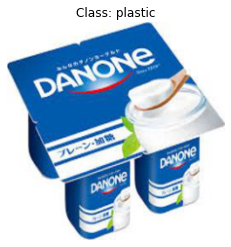

In [73]:
image,label = train_data[8]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class: {full_dataset.classes[label]}")
plt.axis('off')
plt.show()

## 3. Creating the Model

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

This model uses Convolutional Nerual Networks to classify images

In [75]:
class WasteClassifierModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

In [76]:
torch.manual_seed(42)
model_1 = WasteClassifierModelV1(input_shape=3, hidden_units=64, output_shape=len(full_dataset.classes)).to(device)
model_1

WasteClassifierModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### setting up loss function and optimizer

In [77]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

In [78]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [79]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Training model

In [80]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [86]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)

train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []
# Measure time
train_time_start_model_1 = timer()

# Train and test model
epochs = 30
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_loader ,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss, test_acc = test_step(data_loader=test_loader ,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.25839 | Train accuracy: 52.17%


  3%|▎         | 1/30 [02:37<1:15:57, 157.16s/it]

Test loss: 1.18205 | Test accuracy: 54.86%

Epoch: 1
---------
Train loss: 1.21930 | Train accuracy: 54.79%


  7%|▋         | 2/30 [05:13<1:13:09, 156.75s/it]

Test loss: 1.18300 | Test accuracy: 57.64%

Epoch: 2
---------
Train loss: 1.19809 | Train accuracy: 55.89%


 10%|█         | 3/30 [07:49<1:10:19, 156.26s/it]

Test loss: 1.18973 | Test accuracy: 55.90%

Epoch: 3
---------
Train loss: 1.15986 | Train accuracy: 56.58%


 13%|█▎        | 4/30 [10:26<1:07:50, 156.55s/it]

Test loss: 1.10541 | Test accuracy: 58.68%

Epoch: 4
---------
Train loss: 1.15052 | Train accuracy: 57.68%


 17%|█▋        | 5/30 [13:00<1:04:52, 155.69s/it]

Test loss: 1.12226 | Test accuracy: 55.79%

Epoch: 5
---------
Train loss: 1.11763 | Train accuracy: 58.69%


 20%|██        | 6/30 [15:32<1:01:45, 154.38s/it]

Test loss: 1.10078 | Test accuracy: 57.87%

Epoch: 6
---------
Train loss: 1.10151 | Train accuracy: 59.02%


 23%|██▎       | 7/30 [18:04<58:51, 153.56s/it]  

Test loss: 1.08968 | Test accuracy: 58.91%

Epoch: 7
---------
Train loss: 1.07652 | Train accuracy: 61.16%


 27%|██▋       | 8/30 [20:34<55:58, 152.65s/it]

Test loss: 1.05409 | Test accuracy: 60.76%

Epoch: 8
---------
Train loss: 1.04160 | Train accuracy: 62.05%


 30%|███       | 9/30 [23:06<53:18, 152.31s/it]

Test loss: 1.07355 | Test accuracy: 58.56%

Epoch: 9
---------
Train loss: 1.02119 | Train accuracy: 62.62%


 33%|███▎      | 10/30 [25:38<50:42, 152.11s/it]

Test loss: 1.00582 | Test accuracy: 65.74%

Epoch: 10
---------
Train loss: 1.00715 | Train accuracy: 64.20%


 37%|███▋      | 11/30 [28:08<48:03, 151.74s/it]

Test loss: 1.03363 | Test accuracy: 61.81%

Epoch: 11
---------
Train loss: 0.97897 | Train accuracy: 64.70%


 40%|████      | 12/30 [30:40<45:31, 151.78s/it]

Test loss: 1.00173 | Test accuracy: 63.66%

Epoch: 12
---------
Train loss: 0.95220 | Train accuracy: 66.01%


 43%|████▎     | 13/30 [33:12<42:58, 151.66s/it]

Test loss: 0.97399 | Test accuracy: 64.93%

Epoch: 13
---------
Train loss: 0.94922 | Train accuracy: 65.65%


 47%|████▋     | 14/30 [35:43<40:25, 151.60s/it]

Test loss: 0.98529 | Test accuracy: 63.66%

Epoch: 14
---------
Train loss: 0.91609 | Train accuracy: 67.56%


 50%|█████     | 15/30 [38:14<37:49, 151.33s/it]

Test loss: 0.96189 | Test accuracy: 64.70%

Epoch: 15
---------
Train loss: 0.90419 | Train accuracy: 66.90%


 53%|█████▎    | 16/30 [40:45<35:18, 151.31s/it]

Test loss: 1.01483 | Test accuracy: 61.81%

Epoch: 16
---------
Train loss: 0.88908 | Train accuracy: 69.02%


 57%|█████▋    | 17/30 [43:17<32:48, 151.39s/it]

Test loss: 0.95051 | Test accuracy: 67.25%

Epoch: 17
---------
Train loss: 0.85174 | Train accuracy: 68.93%


 60%|██████    | 18/30 [45:53<30:33, 152.80s/it]

Test loss: 0.95232 | Test accuracy: 67.13%

Epoch: 18
---------
Train loss: 0.83998 | Train accuracy: 70.33%


 63%|██████▎   | 19/30 [48:27<28:04, 153.10s/it]

Test loss: 0.96935 | Test accuracy: 66.32%

Epoch: 19
---------
Train loss: 0.84018 | Train accuracy: 70.03%


 67%|██████▋   | 20/30 [51:01<25:33, 153.36s/it]

Test loss: 0.95675 | Test accuracy: 66.78%

Epoch: 20
---------
Train loss: 0.81051 | Train accuracy: 71.04%


 70%|███████   | 21/30 [53:35<23:02, 153.56s/it]

Test loss: 0.91869 | Test accuracy: 66.44%

Epoch: 21
---------
Train loss: 0.78987 | Train accuracy: 71.90%


 73%|███████▎  | 22/30 [56:07<20:24, 153.07s/it]

Test loss: 0.96620 | Test accuracy: 67.13%

Epoch: 22
---------
Train loss: 0.80649 | Train accuracy: 70.62%


 77%|███████▋  | 23/30 [58:37<17:46, 152.31s/it]

Test loss: 0.95524 | Test accuracy: 67.82%

Epoch: 23
---------
Train loss: 0.75762 | Train accuracy: 72.77%


 80%|████████  | 24/30 [1:01:08<15:10, 151.83s/it]

Test loss: 0.97165 | Test accuracy: 67.59%

Epoch: 24
---------
Train loss: 0.71244 | Train accuracy: 73.45%


 83%|████████▎ | 25/30 [1:03:27<12:20, 148.04s/it]

Test loss: 0.92862 | Test accuracy: 68.63%

Epoch: 25
---------
Train loss: 0.70825 | Train accuracy: 74.55%


 87%|████████▋ | 26/30 [1:05:27<09:18, 139.63s/it]

Test loss: 0.95667 | Test accuracy: 67.94%

Epoch: 26
---------
Train loss: 0.68895 | Train accuracy: 74.91%


 90%|█████████ | 27/30 [1:07:27<06:41, 133.78s/it]

Test loss: 0.94352 | Test accuracy: 71.76%

Epoch: 27
---------
Train loss: 0.67216 | Train accuracy: 75.21%


 93%|█████████▎| 28/30 [1:09:28<04:19, 129.78s/it]

Test loss: 0.91892 | Test accuracy: 69.33%

Epoch: 28
---------
Train loss: 0.66423 | Train accuracy: 76.85%


 97%|█████████▋| 29/30 [1:11:28<02:06, 126.97s/it]

Test loss: 0.93320 | Test accuracy: 70.14%

Epoch: 29
---------
Train loss: 0.69006 | Train accuracy: 75.65%


100%|██████████| 30/30 [1:13:28<00:00, 146.95s/it]

Test loss: 0.92142 | Test accuracy: 70.60%

Train time on cuda: 4408.508 seconds


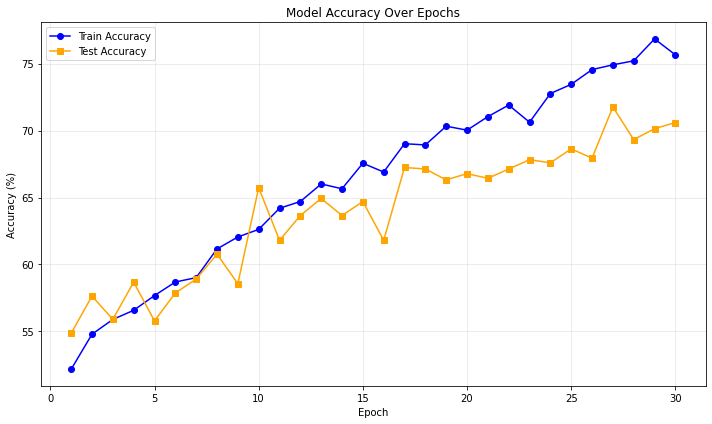

In [87]:
def plot_accuracy_curve(train_accuracies, test_accuracies, epochs):
    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epoch_range, test_accuracies, label='Test Accuracy', marker='s', color='orange')
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_accuracy_curve(train_accuracies, test_accuracies, epochs)

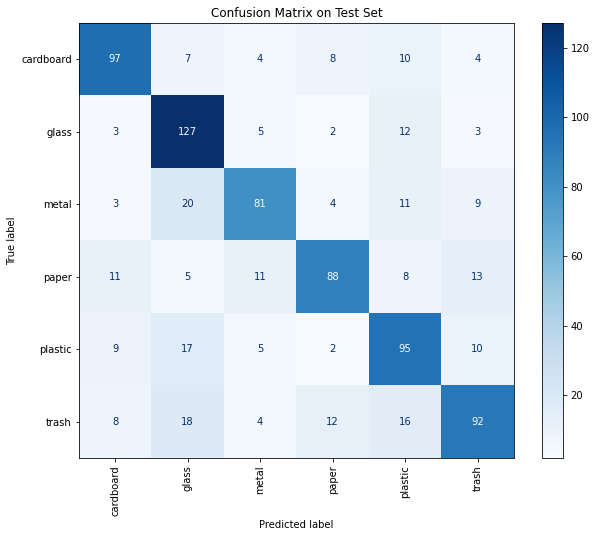

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.74      0.75      0.74       130
       glass       0.65      0.84      0.73       152
       metal       0.74      0.63      0.68       128
       paper       0.76      0.65      0.70       136
     plastic       0.62      0.69      0.66       138
       trash       0.70      0.61      0.65       150

    accuracy                           0.70       834
   macro avg       0.70      0.69      0.69       834
weighted avg       0.70      0.70      0.69       834



In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Run model on test set and collect predictions
model_1.to(device)
model_1.eval()
all_preds = []
all_labels = []
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model_1(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(y.cpu().numpy().tolist())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix on Test Set')
plt.show()

print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

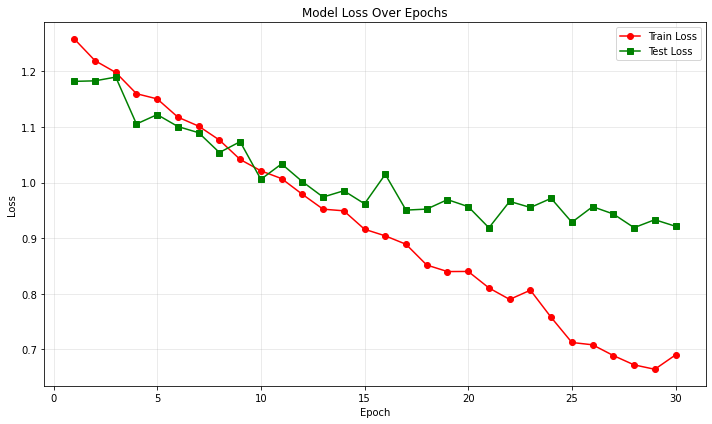

In [89]:
def plot_loss_curve(train_losses, test_losses, epochs):

    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    # Convert tensors to CPU if needed
    train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
    test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
    
    plt.plot(epoch_range, train_losses_cpu, label='Train Loss', marker='o', color='red')
    plt.plot(epoch_range, test_losses_cpu, label='Test Loss', marker='s', color='green')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function with your stored losses
plot_loss_curve(train_losses, test_losses, epochs)

In [84]:

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
else:
    print("GPU NOT detected!")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
GPU Name: NVIDIA GeForce RTX 3070
GPU Count: 1
